# Model Iteration 1 -- Earthquake Dataset

Keenan and James

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

%matplotlib inline

quakes = pd.read_csv("./data/data.csv")

print quakes.head()

                       time  latitude  longitude  depth  mag magType  nst  \
0  1901-08-09T18:33:00.000Z        40        144      0  7.5      mw  NaN   
1  1901-08-09T13:01:00.000Z       -22        170      0  7.9      mw  NaN   
2  1902-04-19T02:23:00.000Z        14        -91      0  7.5      mw  NaN   
3  1902-09-23T20:18:00.000Z        16        -93      0  7.8      mw  NaN   
4  1902-09-22T01:46:00.000Z        18        146      0  7.5      mw  NaN   

   gap  dmin  rms    ...                      updated  \
0  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
1  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
2  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
3  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
4  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   

                                       place        type horizontalError  \
0        off the east coast of Honshu, Japan  earthquake             NaN   
1           southeast of the Loyalty Islan

We wrote some helper functions that will help us test the progress we have made in the models quickly.

In [2]:
from sklearn.cross_validation import train_test_split

def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

### Feature engineering

Because our magnitude is a continuous variable, it makes it hard to predict. We decided to categorize them into standard scales provided by USGS [here](http://www.geo.mtu.edu/UPSeis/magnitude.html). We thought this categorization would simplify the problem and makes sense for making predictions because it will be very hard to give an exact magnitude prediction.

In [3]:
def magclassify(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
# "minor" "light" "moderate" "strong" "major" "great"

In [4]:
quakes["magClassified"] = quakes["mag"].apply(magclassify)
quakes["magClassified"]

0         4
1         4
2         4
3         4
4         4
5         4
6         4
7         4
8         4
9         4
10        4
11        3
12        4
13        5
14        5
15        4
16        3
17        5
18        4
19        2
20        3
21        5
22        3
23        5
24        5
25        4
26        4
27        4
28        3
29        3
         ..
686938    0
686939    1
686940    1
686941    0
686942    1
686943    0
686944    1
686945    1
686946    0
686947    0
686948    1
686949    0
686950    0
686951    0
686952    0
686953    1
686954    0
686955    1
686956    1
686957    1
686958    2
686959    1
686960    0
686961    1
686962    1
686963    1
686964    1
686965    0
686966    1
686967    2
Name: magClassified, dtype: int64

In [5]:
quakes.isnull().sum()

time                    0
latitude                0
longitude               0
depth                   9
mag                     0
magType               132
nst                318203
gap                321998
dmin               605675
rms                203437
net                     0
id                      0
updated                 0
place                  13
type                    0
horizontalError    609417
depthError         459109
magError           607459
magNst             304558
status                  0
locationSource          0
magSource               0
magClassified           0
dtype: int64

We found that there were sum null values in the depth so we decided to fill it with the median since we only have 9 points missing.

In [6]:
quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())

We used two simple models of logisticRegression and RandomForestClassifier to start our training.

In [7]:
logistic = LogisticRegression()
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.7833261520187258

In [8]:
predictors = ["latitude", "longitude", "depth"]
cross_validate(alg, quakes[predictors], quakes["magClassified"])

0.73833134776031006

Another feature we thought would be interesting was classifying magnitude type. We were able to classify the encoding with the following look up there [here](http://earthquake.usgs.gov/earthquakes/eventpage/terms.php).

In [9]:
quakes.magType.unique()

array(['mw', 'mh', 'ml', 'ms', 'mb', 'lg', nan, 'md', 'mc', 'mun', 'mblg',
       'me', 'm', 'mwc', 'mwb', 'mwr', 'Mw', 'mww', 'Ml', 'H', 'mlg', 'Md',
       'Mb', 'mb_lg', 'MbLg', 'ms_20', 'mlr'], dtype=object)

In [10]:
def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8
    

In [11]:
quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
quakes["magTypeClassified"].value_counts()

3    337271
1    156982
0     94543
7     48549
8     37633
2      7218
4      4756
6        16
Name: magTypeClassified, dtype: int64

We were able to increase our score by 4 percent by adding magTypeClassified

In [12]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.84596080166761767

Time is definitely an important variable for our model so we decided to add year month and hour column to see if it will help our model predict better.

In [13]:
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [14]:
quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])

Adding time variables increased our performance by 3 percent

In [15]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.85726263814326142

In [16]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()
# location = geolocator.reverse("-6.0326, 103.7117")
location = geolocator.reverse("42.2926850,-71.2644100")
print location.address

Milas Hall, Olin Way, Needham, Norfolk County, Massachusetts, 02492-1200, United States of America


In [17]:
quakes["fault"] = quakes.place.apply(lambda x: True if "Ridge" in str(x).split() else False)
quakes.fault.value_counts()


False    674520
True      12448
Name: fault, dtype: int64

In [18]:
predicted = np.array(alg.predict_proba(X_test))

print predicted[0]

[ 0.98947368  0.01052632  0.          0.          0.          0.        ]


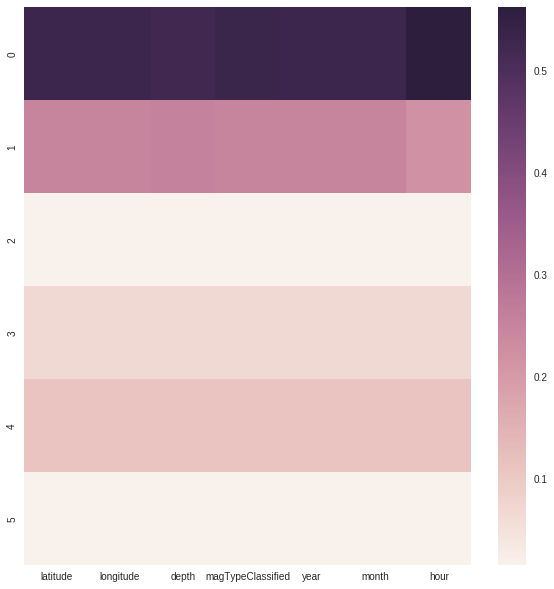

In [21]:
sns.plt.figure(figsize=(10,10))
all_probs = np.zeros((6, 7))
for i in range(7):
    x = np.zeros((1,len(predictors)))
    x[0,i] = 1.0
    all_probs[:,i] = alg.predict_proba(x)
sns.heatmap(all_probs, xticklabels=predictors)

In [36]:
from sklearn.grid_search import GridSearchCV

parameters = [{'min_samples_split': np.arange(1,11)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_leaf=8)

predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
# model.fit(X_train, y_train)
# model.score(X_test, y_test)

clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print clf.grid_scores_

[mean: 0.85563, std: 0.00077, params: {'min_samples_split': 1}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 2}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 3}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 4}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 5}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 6}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 7}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 8}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 9}, mean: 0.85563, std: 0.00077, params: {'min_samples_split': 10}]


# Min_Samples_Leaf Parameter Tune

[mean: 0.84924, std: 0.00067, params: {'min_samples_leaf': 1}, mean: 0.85107, std: 0.00026, params: {'min_samples_leaf': 2}, mean: 0.85379, std: 0.00035, params: {'min_samples_leaf': 3}, mean: 0.85455, std: 0.00041, params: {'min_samples_leaf': 4}, mean: 0.85560, std: 0.00030, params: {'min_samples_leaf': 5}, mean: 0.85539, std: 0.00018, params: {'min_samples_leaf': 6}, mean: 0.85559, std: 0.00012, params: {'min_samples_leaf': 7}, mean: 0.85543, std: 0.00020, params: {'min_samples_leaf': 8}, mean: 0.85598, std: 0.00057, params: {'min_samples_leaf': 9}, mean: 0.85571, std: 0.00018, params: {'min_samples_leaf': 10}]


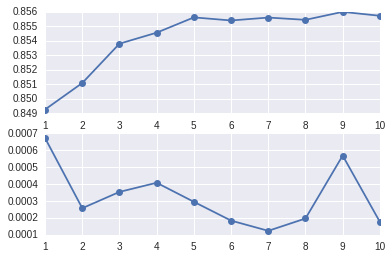

In [39]:
from sklearn.grid_search import GridSearchCV

parameters = [{'min_samples_leaf': np.arange(1,11)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print clf.grid_scores_

res = zip(*[(f1m, f1s.std(), p['min_samples_leaf']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

In [40]:
print clf.best_params_

{'min_samples_leaf': 9}


# Min_Samples_Split Parameter Tune

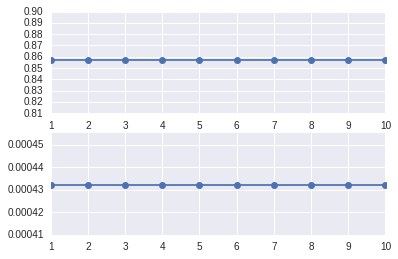

{'min_samples_split': 1}


In [41]:
parameters = [{'min_samples_split': np.arange(1,11)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['min_samples_split']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

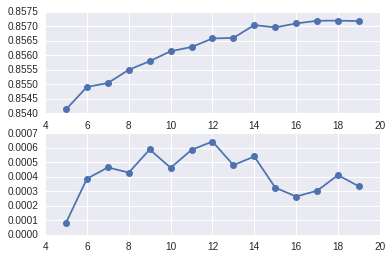

{'n_estimators': 18}


In [42]:
parameters = [{'n_estimators': np.arange(5,20)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['n_estimators']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

In [ ]:
alg.predict()